Let's start by some imports: stats and basic numerical operations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing 
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import seaborn as sb

The data lives into one big csv file. Let's read that in a pandas data frame:

In [3]:
file_data = 'HnuCsub.csv'
data = pd.read_csv(file_data)
data

,network,pair,correlation,days_apart,site_label,site_label_concat,exact_site_label1,exact_site_label2,scanner1,scanner2,scanner_Label,visit1,subject1,visit2,subject2,id1,id2
0,DMN,s0025427-0 vs s0025427-1,0.777,3.0,Hnu,HnuHnu,Hnu0,Hnu1,GE,GE,GEGE,1,s0025427,2,s0025427,s0025427-0,s0025427-1
1,DMN,s0025427-0 vs s0025427-2,0.697,6.0,Hnu,HnuHnu,Hnu0,Hnu2,GE,GE,GEGE,1,s0025427,3,s0025427,s0025427-0,s0025427-2
2,DMN,s0025427-0 vs s0025427-3,0.805,9.0,Hnu,HnuHnu,Hnu0,Hnu3,GE,GE,GEGE,1,s0025427,4,s0025427,s0025427-0,s0025427-3
3,DMN,s0025427-0 vs s0025427-4,0.802,12.0,Hnu,HnuHnu,Hnu0,Hnu4,GE,GE,GEGE,1,s0025427,5,s0025427,s0025427-0,s0025427-4
4,DMN,s0025427-0 vs s0025427-5,0.764,15.0,Hnu,HnuHnu,Hnu0,Hnu5,GE,GE,GEGE,1,s0025427,6,s0025427,s0025427-0,s0025427-5
5,DMN,s0025427-0 vs s0025427-6,0.776,18.0,Hnu,HnuHnu,Hnu0,Hnu6,GE,GE,GEGE,1,s0025427,7,s0025427,s0025427-0,s0025427-6
6,DMN,s0025427-0 vs s0025427-7,0.655,21.0,Hnu,HnuHnu,Hnu0,Hnu7,GE,GE,GEGE,1,s0025427,8,s0025427,s0025427-0,s0025427-7
7,DMN,s0025427-0 vs s0025427-8,0.705,24.0,Hnu,HnuHnu,Hnu0,Hnu8,GE,GE,GEGE,1,s0025427,9,s0025427,s0025427-0,s0025427-8
8,DMN,s0025427-0 vs s0025427-9,0.804,27.0,Hnu,HnuHnu,Hnu0,Hnu9,GE,GE,GEGE,1,s0025427,10,s0025427,s0025427-0,s0025427-9
9,DMN,s0025427-0 vs s0025428-0,0.546,0.0,Hnu,HnuHnu,Hnu0,Hnu0,GE,GE,GEGE,1,s0025427,1,s0025428,s0025427-0,s0025428-0


# List of relevant variables (scan, site, scanner, network)
Let's extract the labels of the network, the ID for each scan, as well as a list of sites:

In [4]:
list_subject = np.unique([data.subject1.values.flatten() , data.subject2.values.flatten()])
list_id = np.unique([data.id1.values.flatten() , data.id2.values.flatten()])
list_net = np.unique(data.network.values.flatten())
print('Number of subjects: %i \nNumber of networks: %i\nNumber of scans: %i' 
      % (list_subject.size , list_net.size , list_id.size))

Number of subjects: 27 
Number of networks: 7
Number of scans: 284


In [5]:
np.sum(data.network=='MOT')

40186

In [6]:
284*283/2

40186.0

# Building similarity matrix
## Spatial similarity
Now, we are going to build the whole matrix of inter-scan comparisons for each network:

In [7]:
all_comp = {}
all_subj = {}
for net in list_net:
    print("%s" % net)
    all_comp[net] = np.zeros([list_id.size,list_id.size])
    all_subj[net] = np.zeros([list_id.size,list_id.size])
    flat_comp = data[:][data.network==net]
    flat_comp.index = range(flat_comp.shape[0])
    for ll in range(flat_comp.shape[0]):
        id1 = flat_comp.id1[ll]
        id2 = flat_comp.id2[ll]
        ind1 = np.where(list_id==id1)
        ind2 = np.where(list_id==id2)
        all_comp[net][ind1,ind2] = flat_comp.correlation[ll]
        all_comp[net][ind2,ind1] = all_comp[net][ind1,ind2]
        ind_subj1 = np.where(list_subject==id1[0:-2])
        ind_subj2 = np.where(list_subject==id2[0:-2])
        if (ind_subj1[0].shape[0] == 0) or (ind_subj2[0].shape[0] == 0):
            if (ind_subj1[0].shape[0] == 0) and (ind_subj2[0].shape[0] == 0):
                all_subj[net][ind2,ind1] = 1
            else:
                all_subj[net][ind2,ind1] = -1
        else:             
            all_subj[net][ind2,ind1] = np.int(id2[0:-2] == id1[0:-2]) * (ind_subj1[0][0]+1)
        all_subj[net][ind1,ind2] = all_subj[net][ind2,ind1] 

CER
DMN
FPN
LIM
MOT
SAL
VIS


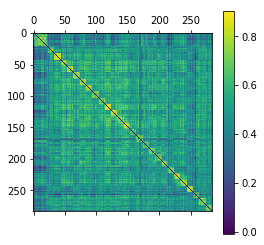

In [8]:
plt.matshow(all_comp['MOT'])
plt.colorbar()

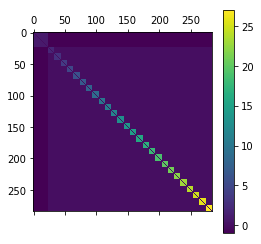

In [9]:
plt.matshow(all_subj['MOT'])
plt.colorbar()

In [21]:
for net in list_net:
    print("\n*******************\n", 
           net, "\n",)
    print("inter-subject consistency (HNU1):", np.mean(all_comp[net][all_subj[net]==0]),
          "  (std ", np.std(all_comp[net][all_subj[net]==0]),")")
    print("consistency Csub vs HNU1:", np.mean(all_comp[net][all_subj[net]==-1]),
          "  (std ", np.std(all_comp[net][all_subj[net]==-1]),")")
    print("Mean consistency HNU1:", np.mean(all_comp[net][all_subj[net]>0]),          
         "   (std ", np.std(all_comp[net][all_subj[net]>0]), ")")
    print("consistency Csub:", np.mean(all_comp[net][all_subj[net]==1]),
          "   (std ", np.std(all_comp[net][all_subj[net] == 1]), ")")
    #for ss in range(0,list_subject.shape[0]):
    #    print("intra-subject ", list_subject[ss],
    #          " consistency:", np.mean(all_comp[net][all_subj[net]==ss+1]))


*******************
 CER 

inter-subject consistency (HNU1): 0.4200648244592856   (std  0.08040664236550495 )
consistency Csub vs HNU1: 0.3710689102564102   (std  0.0742689891635571 )
Mean consistency HNU1: 0.6329273858921162    (std  0.09881682264035262 )
consistency Csub: 0.5906557971014493    (std  0.09057802107120812 )

*******************
 DMN 

inter-subject consistency (HNU1): 0.4772621775626493   (std  0.10461854353264562 )
consistency Csub vs HNU1: 0.3340567307692308   (std  0.07006468613473041 )
Mean consistency HNU1: 0.70015836791148    (std  0.12653795436979165 )
consistency Csub: 0.5627644927536231    (std  0.100162290266394 )

*******************
 FPN 

inter-subject consistency (HNU1): 0.3862384045095276   (std  0.0869306752849606 )
consistency Csub vs HNU1: 0.26225817307692306   (std  0.08743092794180396 )
Mean consistency HNU1: 0.6500145228215768    (std  0.11711191079806983 )
consistency Csub: 0.5291086956521739    (std  0.10736185493647232 )

*******************
 LI

# Running a single fingerprinting experiment

In [11]:
list_id

array(['Chum-0', 'Chum-1', 'Chus-0', 'Chus-1', 'Chus-2', 'Cinq-0',
       'Cinq-1', 'Cinq-2', 'Edm-0', 'Ismd-0', 'Ismd-1', 'Ismd-2',
       'Iugm-0', 'Iugm-1', 'Iugm-2', 'Mni-0', 'Mni-1', 'Mni-3', 'Rri-0',
       'Sask-0', 'Sun-0', 'Twh-0', 'Ubc-0', 'Vic-0', 's0025427-0',
       's0025427-1', 's0025427-2', 's0025427-3', 's0025427-4',
       's0025427-5', 's0025427-6', 's0025427-7', 's0025427-8',
       's0025427-9', 's0025428-0', 's0025428-1', 's0025428-2',
       's0025428-3', 's0025428-4', 's0025428-5', 's0025428-6',
       's0025428-7', 's0025428-8', 's0025428-9', 's0025429-0',
       's0025429-1', 's0025429-2', 's0025429-3', 's0025429-4',
       's0025429-5', 's0025429-6', 's0025429-7', 's0025429-8',
       's0025429-9', 's0025430-0', 's0025430-1', 's0025430-2',
       's0025430-3', 's0025430-4', 's0025430-5', 's0025430-6',
       's0025430-7', 's0025430-8', 's0025430-9', 's0025431-0',
       's0025431-1', 's0025431-2', 's0025431-3', 's0025431-4',
       's0025431-5', 's0025431-6',

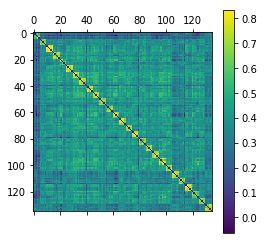

In [12]:
n_time = 5
net = 'FPN'
list_time = []
for subj in list_subject:
    mask = np.zeros(list_id.shape)
    for ll in range(len(list_id)): mask[ll] = subj in list_id[ll]    
    if not np.any(mask):
        for ll in range(len(list_id)): mask[ll] = "s00" not in list_id[ll]    
    ind = np.where(mask)
    ind = ind[0]
    ind = ind[np.random.permutation(len(ind))]
    list_time = list_time + list(list_id[(ind[0:n_time])])
comp_samp = all_comp[net][np.isin(list_id,list_time),:][:,np.isin(list_id,list_time)]
plt.matshow(comp_samp)
plt.colorbar()

# hierarchical clustering

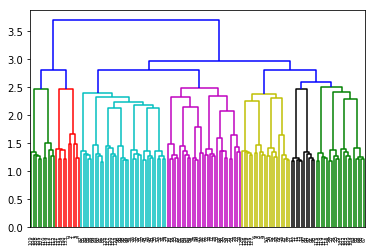

In [13]:
iu = np.triu_indices(comp_samp.shape[0],1)
dist_part = 2-comp_samp[iu]
hier = linkage(dist_part, method="ward") # scipy's hierarchical clustering
res = dendrogram(hier,get_leaves=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on papers from the dendrogram
part = np.squeeze(cut_tree(hier,n_clusters=list_subject.size))

## Visualizing the partition

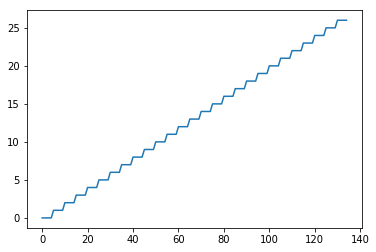

In [14]:
plt.plot(part)


array([21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 26, 26, 26, 26, 26,  0,  0,
        0,  0,  0, 17, 17, 17, 17, 17, 12, 12, 12, 12, 12, 24, 24, 24, 24,
       24, 19, 19, 19, 19, 19,  7,  7,  7,  7,  7,  9,  9,  9,  9,  9,  6,
        6,  6,  6,  6,  3,  3,  3,  3,  3, 16, 16, 16, 16, 16,  8,  8,  8,
        8,  8, 14, 14, 14, 14, 14, 11, 11, 11, 11, 11,  4,  4,  4,  4,  4,
       25, 25, 25, 25, 25,  1,  1,  1,  1,  1, 10, 10, 10, 10, 10, 15, 15,
       15, 15, 15,  2,  2,  2,  2,  2, 18, 18, 18, 18, 18, 23, 23, 23, 23,
       23,  5,  5,  5,  5,  5, 20, 20, 20, 20, 20, 13, 13, 13, 13, 13])

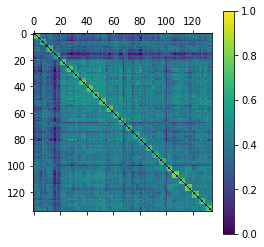

In [15]:
plt.matshow(comp_samp[order,:][:,order],vmin=0,vmax=1)
plt.colorbar()
part[order]

# making stats

In [16]:
def dice(part1,part2):
    d = 2*np.sum((part1==1)&(part2==1))/(np.sum(part1)+np.sum(part2))
    return d

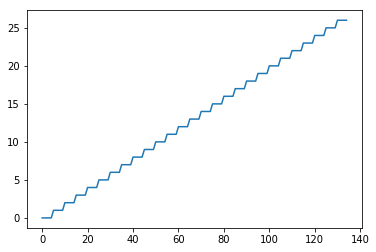

In [17]:
part_ref = np.repeat(range(list_subject.size),n_time)
plt.plot(part_ref)

In [18]:
n_samp = 1000
n_time = 2
succ = np.zeros([n_samp,list_subject.size,list_net.size])
nn = 0
for net in list_net:
    print("%s" % net)
    for ss in range(n_samp):
        list_time = []
        for subj in list_subject:
            mask = np.zeros(list_id.shape)
            for ll in range(len(list_id)): mask[ll] = subj in list_id[ll]    
            if not np.any(mask):
                for ll in range(len(list_id)): mask[ll] = "s00" not in list_id[ll]    
            ind = np.where(mask)
            ind = ind[0]
            ind = ind[np.random.permutation(len(ind))]
            list_time = list_time + list(list_id[(ind[0:n_time])])
        comp_samp = all_comp[net][np.isin(list_id,list_time),:][:,np.isin(list_id,list_time)]
        iu = np.triu_indices(comp_samp.shape[0],1)
        dist_part = 2-comp_samp[iu]
        hier = linkage(dist_part, method="ward") # scipy's hierarchical clustering
        part = np.squeeze(cut_tree(hier,n_clusters=list_subject.size))
        for ssub in range(list_subject.size):
            succ[ss,ssub,nn] = float(part[2*ssub] == part[1+2*ssub]) * float(np.sum(part == part[2*ssub]) == 2)
    nn += 1
succ = np.mean(succ,axis=0)

CER
DMN
FPN
LIM
MOT
SAL
VIS


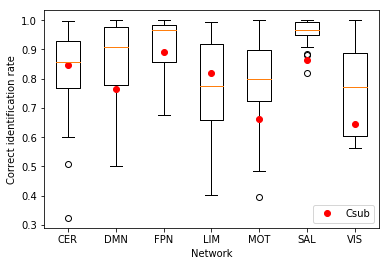

In [19]:
ax = plt.boxplot(succ[1:,:])
plt.plot(range(1,list_net.size+1),succ[0,:],color='red',marker='o',linestyle='none',label='Csub')
plt.legend()
plt.xlabel("Network")
plt.ylabel("Correct identification rate")
loc, labels = plt.xticks(range(1,list_net.size+1),list_net)

In [20]:
plt.plot?